In [54]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
import ffsim
import pyscf
import numpy as np
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
import quces as qs

In [55]:
# Define molecule with pyscf
atom = lambda R: [["H", (0, 0, 0)], ["H", (0, 0, R)]]
R = 0.75  
mol = pyscf.gto.Mole()
mol.build(atom=atom(R),basis="sto-3g",unit="Angstrom")
active_space = range(0, mol.nao_nr()) # complete active space

# Run scf in pyscf and obtain molecular data with ffsim
scf = pyscf.scf.RHF(mol).run()
mol_data = ffsim.MolecularData.from_scf(scf, active_space=active_space)
norb     = mol_data.norb
nelec = mol_data.nelec
scf = pyscf.scf.RHF(mol).run(verbose=0)
norb = len(active_space)
nelec = int(sum(scf.mo_occ[active_space]))
cas = pyscf.mcscf.RCASCI(scf, ncas=norb, nelecas=nelec)
cas.kernel(verbose=0)
E_FCI = cas.e_tot
print("E_FCI = ", E_FCI)

converged SCF energy = -1.1161514489386
CASCI E = -1.13711706734573  E(CI) = -1.84268668190573  S^2 = 0.0000000
E_FCI =  -1.137117067345732


In [56]:
# create an empty of 2*norb qubits circuit
qreg = QuantumRegister(2*norb, "q")
circ = QuantumCircuit(qreg)

In [ ]:
from qiskit_aer import AerSimulator
import quces.utils as qcu

simulator = AerSimulator(method="matrix_product_state")
pairs_aa = [(p, p+1) for p in range(norb-1)]
pairs_ab = [(p, p) for p in range(norb)]
hf = qs.hf.hartree_fock(norb, nelec)
lucj = qs.variational.lucj(norb, (pairs_aa,pairs_ab), n_reps=1, with_final_orbital_rotation = True)
ansatz = QuantumCircuit(hf.num_qubits, name="HF+LUCJ")
ansatz.compose(hf, inplace=True)
ansatz.compose(lucj, inplace=True, front=False)
print("qubits:", lucj.num_qubits, "parameters:", len(lucj.parameters))

qubits: 4 parameters: 11


# Parametrized LuCJ ansatz + HF initial state for $H_2$ in STO-3G

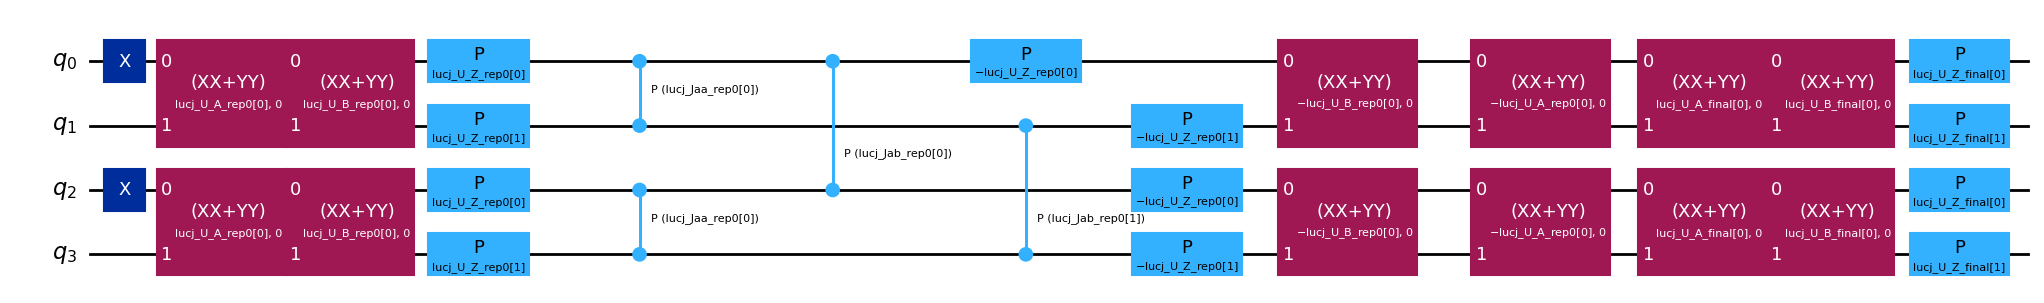

In [58]:
ansatz.draw("mpl", fold=-1)

In [59]:
# Define Qubit Hamiltonian with ffsim molecular data 
H_f = ffsim.fermion_operator(mol_data.hamiltonian) 
H = ffsim.qiskit.jordan_wigner(H_f, norb=norb)

params = qs.variational.lucj_parameter_order(
    lucj, norb, n_reps=1, parameter_prefix="lucj",
    with_final_orbital_rotation=True,
    pairs_aa=pairs_aa, pairs_ab=pairs_ab
)

rng = np.random.default_rng()
x0 = rng.normal(0.0001, 0.1, size=len(params)) # small angle parameters

bind = qs.variational.bind_from_vector(params, np.asarray(x0, float))  
circ = ansatz.assign_parameters(bind, inplace=False, strict=True)
lucj_energy = qcu.circuit_energy(simulator, circ, H)

print(f"---- MPS LuCJ circuit simulation energy ----")
print(f"Randomized parameters, E_lucj(random) = {lucj_energy} Ha")
print("Absolute error = ", np.abs(E_FCI - lucj_energy), "Ha")

---- MPS LuCJ circuit simulation energy ----
Randomized parameters, E_lucj(random) = -1.1117268772960307 Ha
Absolute error =  0.025390190049701333 Ha


This shows the nature of the LUCJ ansatz as a variational ansatz. We must perform variational optimization.

# **Variational optimization** - Random parameters

We define the loss function as the expectation value of the Hamiltonian observable and minimize accordingly with VQE.

The Hamiltonian is the qubit Molecular Hamiltonian, and we define the loss function $\mathcal{L}(\vec\theta)$ for the optimizer as:

\begin{align}
\begin{split}
    E(\vec \theta) &= \bra{\psi(\vec \theta)} \hat H \ket{\psi(\vec \theta)} \\
    = \sum_{pq}\bra{\psi(\vec\theta)}\tilde h_q^p\hat P_q^p&\ket{\psi(\vec\theta)} + \sum_{pqrs}\bra{\psi(\vec\theta)}\tilde g_{rs}^{pq}\hat P_{rs}^{pq}\ket{\psi(\vec\theta)}\,,
\end{split}
\end{align}

We wish to optimize the parameters $\vec\theta$.

### Important considerations:

If we start with LUCJ with all $\vec\theta = \vec0$, the gradient is zero. HF is preserved by the number-number terms, so $[\hat H, \hat J_m] = 0$ and the parameter configuration $K_m = J_m = 0$ is a stationary point. We will observe that we either obtain just the HF initial state solution of our circuit, or actually reach FCI.

In [60]:
pairs_aa = [(p, p+1) for p in range(norb-1)]
pairs_ab = [(p, p) for p in range(norb)]
hf = qs.hf.hartree_fock(norb, nelec)
lucj = qs.variational.lucj(norb, (pairs_aa,pairs_ab), n_reps=1, with_final_orbital_rotation = True)
ansatz = QuantumCircuit(hf.num_qubits, name="HF+LUCJ")
ansatz.compose(hf, inplace=True)
ansatz.compose(lucj, inplace=True, front=False)

# **COBYLA**

In [61]:
from functools import partial
from qiskit_algorithms import VQE
from scipy.optimize import minimize
estimator = StatevectorEstimator()

In [62]:
for i in range(10):
    # Give it some random parameters every time
    rng = np.random.default_rng()
    x0 = rng.normal(0.0001, 0.1, size=len(params)) 
    optimizer = partial(minimize, method="COBYLA", options=dict(maxiter=500))
    res = VQE(estimator, ansatz, optimizer, initial_point = x0)
    E_cobyla = res.compute_minimum_eigenvalue(H).optimal_value
    print("E_lucj(VQE-COBYLA) = ", E_cobyla, "Absolute Error", np.abs(E_FCI - E_cobyla), "Ha")

E_lucj(VQE-COBYLA) =  -1.1371170624141498 Absolute Error 4.931582253675515e-09 Ha
E_lucj(VQE-COBYLA) =  -1.1371170660067638 Absolute Error 1.3389682695930105e-09 Ha
E_lucj(VQE-COBYLA) =  -1.1371170672441042 Absolute Error 1.016278172727425e-10 Ha
E_lucj(VQE-COBYLA) =  -1.1371170666494201 Absolute Error 6.963118970304549e-10 Ha
E_lucj(VQE-COBYLA) =  -1.116151448726789 Absolute Error 0.020965618618943083 Ha
E_lucj(VQE-COBYLA) =  -1.1161513938737413 Absolute Error 0.020965673471990742 Ha
E_lucj(VQE-COBYLA) =  -1.137117066347812 Absolute Error 9.979199688814333e-10 Ha
E_lucj(VQE-COBYLA) =  -1.1371170665913992 Absolute Error 7.543328184311804e-10 Ha
E_lucj(VQE-COBYLA) =  -1.116151446770281 Absolute Error 0.020965620575450927 Ha
E_lucj(VQE-COBYLA) =  -1.1371170671119515 Absolute Error 2.337805504737389e-10 Ha


As we can see, sometimes we are lucky and obtain the FCI solution, however other times we reach the local minima (HF solution). We shall initialize the LUCJ parameters from truncated, doubly factorized low-rank decomposition of CCSD $t_2$ amplitudes to avoid the HF stationary point.

# **SPSA**

https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.optimizers.SPSA.html

In [75]:
# Define the loss function 
param_tuple = tuple(ansatz.parameters)
def loss(xvec):
    return float(estimator.run([(ansatz, H, {param_tuple: np.asarray(xvec, float)})]).result()[0].data.evs)

In [77]:
from qiskit_algorithms.optimizers import SPSA

for i in range(10):
    rng = np.random.default_rng()
    x0 = rng.normal(0, np.pi, size=len(params)) 
    lr_gen, pr_gen = SPSA.calibrate(loss=loss,initial_point=x0) 
    spsa = SPSA(maxiter=500, learning_rate=lr_gen, perturbation=pr_gen, blocking=True)
    res = spsa.minimize(loss, x0=x0)
    E_spsa = res.fun
    print("E_lucj(VQE-SPSA) = ", E_spsa, "Ha, Absolute error = ", np.abs(E_FCI - E_spsa), "Ha")

E_lucj(VQE-SPSA) =  -1.1161514489354074 Ha, Absolute error =  0.020965618410324627 Ha
E_lucj(VQE-SPSA) =  -1.1161514476183536 Ha, Absolute error =  0.020965619727378426 Ha
E_lucj(VQE-SPSA) =  -1.1371165520154052 Ha, Absolute error =  5.153303268556897e-07 Ha
E_lucj(VQE-SPSA) =  -1.1371160579568556 Ha, Absolute error =  1.0093888764828307e-06 Ha
E_lucj(VQE-SPSA) =  -1.1319026642449745 Ha, Absolute error =  0.005214403100757492 Ha
E_lucj(VQE-SPSA) =  -1.116151446782806 Ha, Absolute error =  0.020965620562926057 Ha
E_lucj(VQE-SPSA) =  -1.1161514488051045 Ha, Absolute error =  0.020965618540627506 Ha
E_lucj(VQE-SPSA) =  -1.1161513583629012 Ha, Absolute error =  0.02096570898283079 Ha
E_lucj(VQE-SPSA) =  -1.1371021103285937 Ha, Absolute error =  1.4957017138383932e-05 Ha
E_lucj(VQE-SPSA) =  -1.1367873614904425 Ha, Absolute error =  0.00032970585528957486 Ha


# **QN-SPSA**
https://qiskit-community.github.io/qiskit-algorithms/_modules/qiskit_algorithms/optimizers/qnspsa.html#QNSPSA

[1] J. Gacon et al, “Simultaneous Perturbation Stochastic Approximation of the Quantum Fisher Information”, arXiv:2103.09232

In [78]:
from qiskit_algorithms.optimizers import QNSPSA

lr_gen, pr_gen = SPSA.calibrate(loss=loss,initial_point=x0)
for i in range(10):
    rng = np.random.default_rng()
    x0 = rng.normal(0, np.pi, size=len(params)) 
    lr_gen, pr_gen = SPSA.calibrate(loss=loss,initial_point=x0) 
    sampler = StatevectorSampler()
    fidelity = QNSPSA.get_fidelity(ansatz, sampler)
    qnspsa = QNSPSA(fidelity, maxiter=500, learning_rate=lr_gen, perturbation=pr_gen)
    res = qnspsa.minimize(loss, x0=x0)
    E_qnspsa = res.fun
    print("E_lucj(VQE-QNSPSA)", E_qnspsa, "Ha, Absolute error = ", np.abs(E_FCI - E_qnspsa), "Ha")

E_lucj(VQE-QNSPSA) -1.1361992218996109 Ha, Absolute error =  0.0009178454461211683 Ha
E_lucj(VQE-QNSPSA) -1.1161514489295725 Ha, Absolute error =  0.020965618416159515 Ha
E_lucj(VQE-QNSPSA) -1.1161514487459203 Ha, Absolute error =  0.02096561859981172 Ha
E_lucj(VQE-QNSPSA) -1.1371166335888538 Ha, Absolute error =  4.337568781931367e-07 Ha
E_lucj(VQE-QNSPSA) -1.137112076043267 Ha, Absolute error =  4.9913024651182525e-06 Ha
E_lucj(VQE-QNSPSA) -1.116151443944448 Ha, Absolute error =  0.02096562340128405 Ha
E_lucj(VQE-QNSPSA) -1.1371119155879166 Ha, Absolute error =  5.151757815458069e-06 Ha
E_lucj(VQE-QNSPSA) -1.1161514489372075 Ha, Absolute error =  0.02096561840852451 Ha
E_lucj(VQE-QNSPSA) -1.1371170347158173 Ha, Absolute error =  3.2629914770154755e-08 Ha
E_lucj(VQE-QNSPSA) -1.1161514489385849 Ha, Absolute error =  0.02096561840714717 Ha


In [80]:
from qiskit_algorithms.optimizers import QNSPSA
# CCSD
ccsd = pyscf.cc.RCCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space])
ccsd.kernel()
lr_gen, pr_gen = SPSA.calibrate(loss=loss,initial_point=x0)
lucj_ccsd = ffsim.UCJOpSpinBalanced.from_t_amplitudes(t2= ccsd.t2,t1=ccsd.t1,n_reps=1,interaction_pairs=(pairs_aa,pairs_ab))
x0 = lucj_ccsd.to_parameters(interaction_pairs=(pairs_aa, pairs_ab)) 
lr_gen, pr_gen = SPSA.calibrate(loss=loss,initial_point=x0) 
sampler = StatevectorSampler()
fidelity = QNSPSA.get_fidelity(ansatz, sampler)
qnspsa = QNSPSA(fidelity, maxiter=100, learning_rate=lr_gen, perturbation=pr_gen)
res = qnspsa.minimize(loss, x0=x0)
E_qnspsa = res.fun
print("E_lucj(VQE-QNSPSA)", E_qnspsa, "Ha, Absolute error = ", np.abs(E_FCI - E_qnspsa), "Ha")

E(CCSD) = -1.137117245163172  E_corr = -0.02096579622456951
E_lucj(VQE-QNSPSA) -1.1161506727729609 Ha, Absolute error =  0.020966394572771163 Ha
